In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from training_utils import CIFAR10_dataloaders, training_monitor
import optuna

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [2]:
#!pip install optuna

In [3]:
class DynamicMLP(nn.Module):
    def __init__(self, input_shape, hidden_sizes=[512, 256], output_size=10):
        super().__init__()
        # Compute input size dynamically
        input_dim = torch.prod(torch.tensor(input_shape)).item()
        
        # Construct layer sizes dynamically
        layer_sizes = [input_dim] + hidden_sizes + [output_size]

        # Create layers using nn.Sequential
        layers = []
        layers.append(nn.Flatten())
        for in_dim, out_dim in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            if out_dim != output_size:  # Add ReLU except for the last layer
                layers.append(nn.ReLU())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [4]:
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_int("batch_size", 32, 512, step=32)

    # Vary the number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1, 5)  # Choose between 1 to 5 layers

    # Sample hidden layer sizes dynamically
    hidden_sizes = [
        trial.suggest_int(f"hidden_size_{i}", 64, 1024, step=64) for i in range(num_layers)
    ]

    # Define model dynamically
    model = DynamicMLP(input_shape=(3, 32, 32), hidden_sizes=hidden_sizes, output_size=10)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    model.to(device)

    trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=batch_size)

    max_epochs = 10
    for epoch in range(max_epochs):
        model.train()
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{max_epochs} - Accuracy: {accuracy}%")

        # Report intermediate accuracy for pruning
        trial.report(accuracy, epoch)

        # Prune if necessary
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

# Run optimization with TPE + Pruner
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=1, n_warmup_steps=3, interval_steps=1),
)
study.optimize(objective, n_trials=20)

# Best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-03-21 13:50:54,334] A new study created in memory with name: no-name-4a5e2cff-6360-4499-838a-68f6ec603671


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 41.64%
Epoch 2/10 - Accuracy: 46.23%
Epoch 3/10 - Accuracy: 47.87%
Epoch 4/10 - Accuracy: 49.58%
Epoch 5/10 - Accuracy: 50.84%
Epoch 6/10 - Accuracy: 50.87%
Epoch 7/10 - Accuracy: 50.93%
Epoch 8/10 - Accuracy: 51.51%
Epoch 9/10 - Accuracy: 51.36%


[I 2025-03-21 13:51:56,602] Trial 0 finished with value: 51.45 and parameters: {'lr': 0.005740247012240389, 'batch_size': 384, 'num_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 704, 'hidden_size_2': 512}. Best is trial 0 with value: 51.45.


Epoch 10/10 - Accuracy: 51.45%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 10.0%
Epoch 2/10 - Accuracy: 10.0%
Epoch 3/10 - Accuracy: 10.0%


[I 2025-03-21 13:52:31,124] Trial 1 pruned. 


Epoch 4/10 - Accuracy: 10.0%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 39.88%
Epoch 2/10 - Accuracy: 44.31%
Epoch 3/10 - Accuracy: 46.12%


[I 2025-03-21 13:53:36,958] Trial 2 pruned. 


Epoch 4/10 - Accuracy: 46.67%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 10.08%
Epoch 2/10 - Accuracy: 10.01%
Epoch 3/10 - Accuracy: 10.0%


[I 2025-03-21 13:54:02,951] Trial 3 pruned. 


Epoch 4/10 - Accuracy: 10.19%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 44.88%
Epoch 2/10 - Accuracy: 47.76%
Epoch 3/10 - Accuracy: 49.76%
Epoch 4/10 - Accuracy: 50.29%
Epoch 5/10 - Accuracy: 51.41%
Epoch 6/10 - Accuracy: 52.03%
Epoch 7/10 - Accuracy: 52.84%
Epoch 8/10 - Accuracy: 52.37%
Epoch 9/10 - Accuracy: 53.27%


[I 2025-03-21 13:55:07,297] Trial 4 finished with value: 53.85 and parameters: {'lr': 0.0001820153708269262, 'batch_size': 320, 'num_layers': 2, 'hidden_size_0': 640, 'hidden_size_1': 64}. Best is trial 4 with value: 53.85.


Epoch 10/10 - Accuracy: 53.85%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 10.0%
Epoch 2/10 - Accuracy: 10.0%
Epoch 3/10 - Accuracy: 10.0%


[I 2025-03-21 13:55:32,614] Trial 5 pruned. 


Epoch 4/10 - Accuracy: 10.0%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 38.33%
Epoch 2/10 - Accuracy: 42.81%
Epoch 3/10 - Accuracy: 40.93%


[I 2025-03-21 13:55:56,235] Trial 6 pruned. 


Epoch 4/10 - Accuracy: 37.99%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 10.0%
Epoch 2/10 - Accuracy: 10.0%
Epoch 3/10 - Accuracy: 10.0%


[I 2025-03-21 13:56:21,739] Trial 7 pruned. 


Epoch 4/10 - Accuracy: 10.0%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 10.0%
Epoch 2/10 - Accuracy: 10.0%
Epoch 3/10 - Accuracy: 10.0%


[I 2025-03-21 13:57:45,630] Trial 8 pruned. 


Epoch 4/10 - Accuracy: 10.0%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 10.02%
Epoch 2/10 - Accuracy: 10.0%
Epoch 3/10 - Accuracy: 10.0%


[I 2025-03-21 13:58:12,959] Trial 9 pruned. 


Epoch 4/10 - Accuracy: 10.0%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 38.25%
Epoch 2/10 - Accuracy: 41.32%
Epoch 3/10 - Accuracy: 43.46%


[I 2025-03-21 13:58:36,522] Trial 10 pruned. 


Epoch 4/10 - Accuracy: 44.47%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 46.55%
Epoch 2/10 - Accuracy: 50.09%
Epoch 3/10 - Accuracy: 52.25%
Epoch 4/10 - Accuracy: 53.35%
Epoch 5/10 - Accuracy: 53.49%
Epoch 6/10 - Accuracy: 55.15%
Epoch 7/10 - Accuracy: 55.19%
Epoch 8/10 - Accuracy: 55.64%
Epoch 9/10 - Accuracy: 54.98%


[I 2025-03-21 13:59:40,148] Trial 11 finished with value: 55.0 and parameters: {'lr': 0.000433577954972194, 'batch_size': 288, 'num_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 1024, 'hidden_size_2': 768}. Best is trial 11 with value: 55.0.


Epoch 10/10 - Accuracy: 55.0%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 45.22%
Epoch 2/10 - Accuracy: 50.02%
Epoch 3/10 - Accuracy: 50.97%
Epoch 4/10 - Accuracy: 52.76%
Epoch 5/10 - Accuracy: 53.57%
Epoch 6/10 - Accuracy: 54.15%
Epoch 7/10 - Accuracy: 54.22%
Epoch 8/10 - Accuracy: 55.1%
Epoch 9/10 - Accuracy: 54.73%


[I 2025-03-21 14:00:42,159] Trial 12 finished with value: 54.87 and parameters: {'lr': 0.00024548146735094487, 'batch_size': 288, 'num_layers': 2, 'hidden_size_0': 320, 'hidden_size_1': 1024}. Best is trial 11 with value: 55.0.


Epoch 10/10 - Accuracy: 54.87%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 46.13%
Epoch 2/10 - Accuracy: 50.68%
Epoch 3/10 - Accuracy: 52.2%
Epoch 4/10 - Accuracy: 53.52%
Epoch 5/10 - Accuracy: 53.99%
Epoch 6/10 - Accuracy: 53.42%
Epoch 7/10 - Accuracy: 54.64%
Epoch 8/10 - Accuracy: 54.84%
Epoch 9/10 - Accuracy: 54.07%


[I 2025-03-21 14:01:45,147] Trial 13 finished with value: 55.08 and parameters: {'lr': 0.0009364369834672543, 'batch_size': 256, 'num_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 1024, 'hidden_size_2': 1024}. Best is trial 13 with value: 55.08.


Epoch 10/10 - Accuracy: 55.08%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 46.65%
Epoch 2/10 - Accuracy: 50.17%
Epoch 3/10 - Accuracy: 51.09%


[I 2025-03-21 14:02:15,492] Trial 14 pruned. 


Epoch 4/10 - Accuracy: 51.72%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 47.14%
Epoch 2/10 - Accuracy: 49.85%
Epoch 3/10 - Accuracy: 51.76%
Epoch 4/10 - Accuracy: 53.06%


[I 2025-03-21 14:03:04,344] Trial 15 pruned. 


Epoch 5/10 - Accuracy: 53.48%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 46.08%
Epoch 2/10 - Accuracy: 49.93%
Epoch 3/10 - Accuracy: 51.74%


[I 2025-03-21 14:03:30,484] Trial 16 pruned. 


Epoch 4/10 - Accuracy: 52.46%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 45.54%
Epoch 2/10 - Accuracy: 49.22%
Epoch 3/10 - Accuracy: 52.09%


[I 2025-03-21 14:03:55,855] Trial 17 pruned. 


Epoch 4/10 - Accuracy: 52.63%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 44.86%
Epoch 2/10 - Accuracy: 48.58%
Epoch 3/10 - Accuracy: 49.78%


[I 2025-03-21 14:04:28,556] Trial 18 pruned. 


Epoch 4/10 - Accuracy: 52.0%
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10 - Accuracy: 47.47%
Epoch 2/10 - Accuracy: 51.56%
Epoch 3/10 - Accuracy: 53.18%
Epoch 4/10 - Accuracy: 54.26%
Epoch 5/10 - Accuracy: 55.0%
Epoch 6/10 - Accuracy: 54.79%
Epoch 7/10 - Accuracy: 54.7%
Epoch 8/10 - Accuracy: 55.09%
Epoch 9/10 - Accuracy: 54.51%


[I 2025-03-21 14:09:24,546] Trial 19 finished with value: 54.61 and parameters: {'lr': 0.0004316323593130775, 'batch_size': 32, 'num_layers': 2, 'hidden_size_0': 448, 'hidden_size_1': 768}. Best is trial 13 with value: 55.08.


Epoch 10/10 - Accuracy: 54.61%
Best Hyperparameters: {'lr': 0.0009364369834672543, 'batch_size': 256, 'num_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 1024, 'hidden_size_2': 1024}


Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/30 [00:00<?, ?it/s]

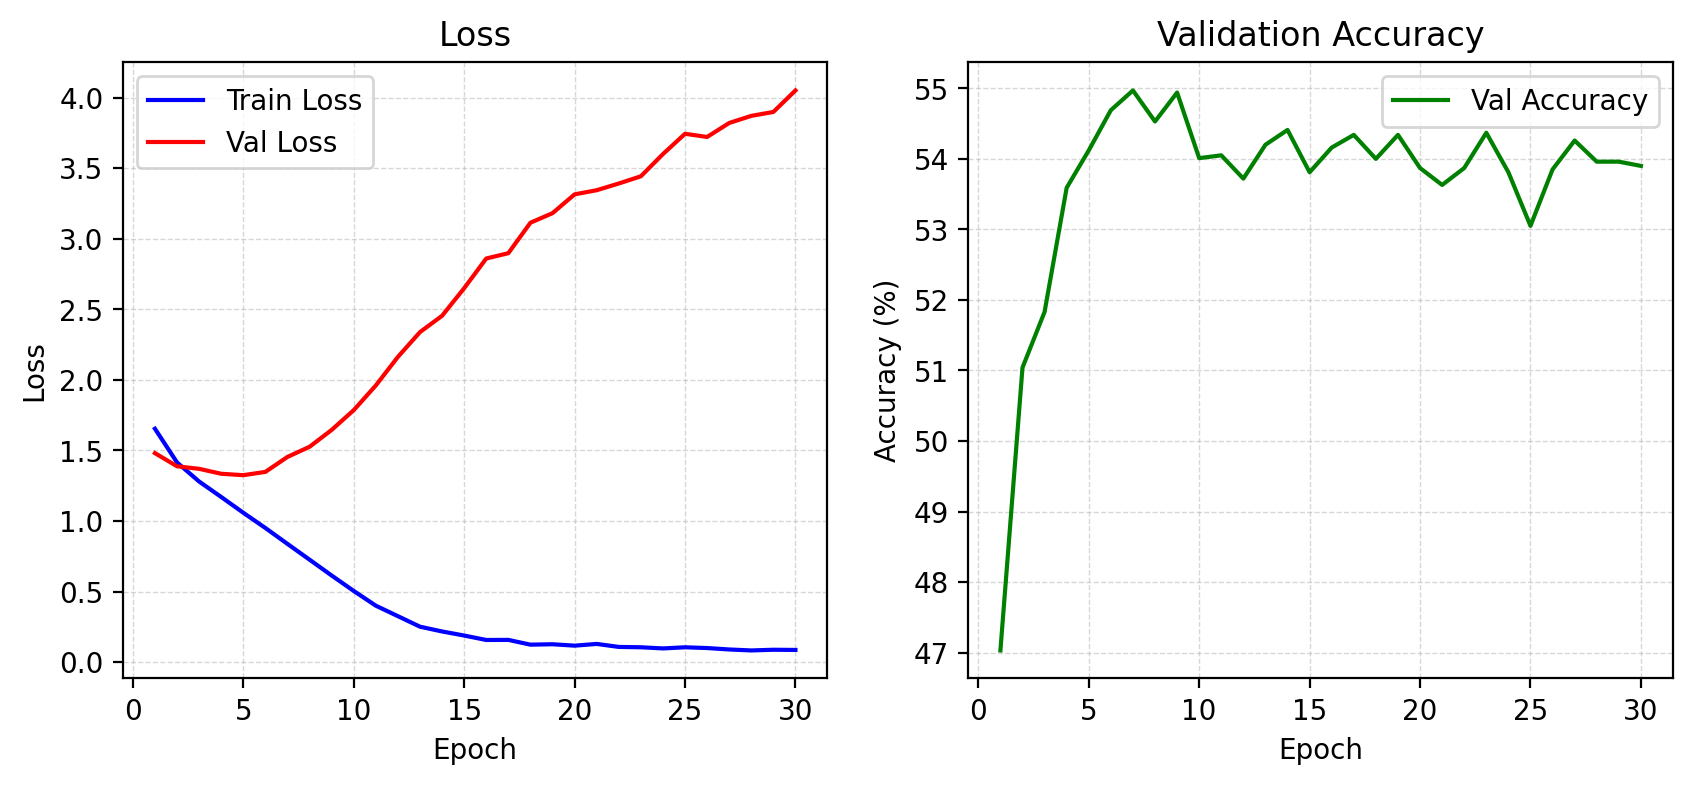

Epoch 30/30: 100%|##########| 30/30 [02:29<00:00,  4.99s/it]

|       Epoch        |     Train loss     |  Validation loss   | Validation accuracy, %  |
__________________________________________________________________________________________
|         1          |       1.6538       |       1.4809       |         47.0300         |
|         2          |       1.4147       |       1.3876       |         51.0400         |
|         3          |       1.2796       |       1.3697       |         51.8300         |
|         4          |       1.1701       |       1.3347       |         53.5900         |
|         5          |       1.0584       |       1.3247       |         54.1200         |
|         6          |       0.9503       |       1.3480       |         54.6900         |
|         7          |       0.8376       |       1.4541       |         54.9700         |
|         8          |       0.7258       |       1.5259       |         54.5300         |
|         9          |       0.6136       |       1.6454       |         54.9400         |

In [6]:
trainloader, testloader, classes = CIFAR10_dataloaders(batch_size=256)

model = DynamicMLP((32, 32, 3), [256, 1024, 1024], 10).to(device) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0009364369834672543)
num_epochs = 30

trained_model = training_monitor(device, model, optimizer, criterion, num_epochs, trainloader, testloader)